# Duplicates: Find Near Duplicate Data Samples

Discover near duplicate data samples, which might indicate that there is not enough variation in the dataset.

Please see the [doc page](https://apple.github.io/dnikit/introspectors/data_introspection/duplicates.html) on near duplicate discovery and removal for a description of the problem, the
[Duplicates](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.Duplicates) introspector,
and what actions can be taken to improve the dataset.

For a more detailed guide on using all of these DNIKit components, try the [Familiarity for Rare Data Discovery Notebook](familiarity_for_rare_data_discovery.ipynb).

## 1. Setup

Here, the required imports are grouped together, and then the desired paths are set.

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

from dnikit.base import pipeline, ImageFormat
from dnikit.processors import Cacher, ImageResizer, Pooler
from dnikit_tensorflow import TFDatasetExamples, TFModelExamples

# For future protection, any deprecated DNIKit features will be treated as errors
from dnikit.exceptions import enable_deprecation_warnings
enable_deprecation_warnings()

## Optional: Download MobileNet and CIFAR-10
This example uses [MobileNet](https://keras.io/api/applications/mobilenet/) (trained on ImageNet) and [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), but feel free to use any other model and dataset. This notebook also uses [TFModelExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFModelExamples) and [TFDatasetExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFDatasetExamples) to load in MobileNet and CIFAR-10. Please see the docs for information about how to [load a model](https://apple.github.io/dnikit/how_to/connect_model.html) or [dataset](https://apple.github.io/dnikit/how_to/connect_data.html). [This doc page](https://apple.github.io/dnikit/how_to/connect_model.html) also describes how responses can be collected outside of DNIKit, and passed into Familiarity via a [Producer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer).

**No processing is done at this point!** Batches are only pulled from the Producer and through the pipeline when the Dataset Report "introspects".

In [2]:
# Load CIFAR10 dataset
# :: Note: max_samples makes it only go up to that many data samples. Remove to run on entire dataset.
cifar10 = TFDatasetExamples.CIFAR10(attach_metadata=True)

# Create a subset of the CIFAR dataset that produces only automobiles
cifar10_cars = cifar10.subset(datasets=['train'], labels=['automobile'], max_samples=1000)

# Load the MobileNet model
# :: Note: If loading a model from tensorflow,
# :: see dnikit_tensorflow's load_tf_model_from_path method.
mobilenet = TFModelExamples.MobileNet()
mobilenet_preprocessor = mobilenet.preprocessing
assert mobilenet_preprocessor is not None

requested_response = 'conv_pw_13'

# Create a pipeline, feeding CIFAR data into MobileNet,
# and observing responses from layer conv_pw_13
producer = pipeline(
    # Pull from the CIFAR dataset subset that was created earlier,
    # so that only 1000 samples are analyzed in the "automobile" class here
    cifar10_cars,
    
    # Preprocess the image batches in the manner expected by MobileNet
    mobilenet_preprocessor,

    # Resize images to fit the input of MobileNet, (224, 224) using an ImageResizer
    ImageResizer(pixel_format=ImageFormat.HWC, size=(224, 224)),

    # Run inference with MobileNet and extract intermediate embeddings
    # (this time, just `conv_pw_13`, but other layers can be added)
    # :: Note: This auto-detects the input layer and connects up 'images' to it:
    mobilenet.model(requested_responses=[requested_response]),

    # Max pool the responses before DNIKit processing using a DNIKit Pooler
    Pooler(dim=(1, 2), method=Pooler.Method.MAX),

    # Cache responses
    Cacher()
)

2023-08-03 12:40:58.899809: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-03 12:40:58.899833: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-03 12:40:58.899836: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-03 12:40:58.899863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 12:40:58.899876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:dnikit_tensorflow.TF2:Instantiating TF2 Model


INFO:dnikit_tensorflow.TF2:GPUs Available: 1


### (Optional) Perform Dimension Reduction

Although the [Duplicates](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.Duplicates) algorithm can run data with any number of dimensions, there will be improved performance and near identical results if the number of dimensions is reduced. The DNIKit [DimensionReduction](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.DimensionReduction) introspector can be used for this.

In [3]:
from dnikit.introspectors import DimensionReduction

dimension_reduction = DimensionReduction.introspect(
    producer, strategies=DimensionReduction.Strategy.PCA(40))
reduced_producer = pipeline(
    producer,
    dimension_reduction,
)

## 2. Look for duplication in embedding space using Duplicates introspector

In this step, use the Duplicates introspector to build the clusters of duplicates.  This can consume
a `producer` or `reduced_producer` with no other arguments and give good results.

In some cases, it might be necessary to refine the results.  The first way to do this is by modifying the `threshold` parameter to the `introspect()` function, of type `Duplicates.ThresholdStrategy`. For using the `percentile` or
`close_sensitivity` parameters to the `introspect()` call.  By default the introspector will use a
dynamic method to find the bend in the sorted distances.  The sensitivity can be controlled with
`close_sensitivity` -- the default value is 5.  Setting it to 2 will give more duplicates and a sensitivity of
20 will produce fewer.  The `percentile` will use the given percentile in the distance as the "close"
threshold.  For example a `percentile` value of `99.5` would take the 99.5th percentile distance and consider that
"close" when building thresholds.  A lower value would produce more duplicates.

The other way to refine the results is to sort or filter the clusters.  They can be sorted by the
mean distance to the centroid of the cluster to see the tightest clusters first.  For example, filter out
clusters larger than `N` to avoid seeing any very large clusters.

In [4]:
from dnikit.introspectors import Duplicates

duplicates = Duplicates.introspect(reduced_producer)

print(f"Found {len(duplicates.results[requested_response])} unique clusters of duplicates.")

INFO:dnikit.base._cached_producer.Cacher:Using cached batches. Attempting to retrieve values..


Found 48 unique clusters of duplicates.


## 3. Manual analysis of near duplicates - Images

Now that sets of the most similar images have been computed, visually inspect them and note which data to consider removing before training. All data displayed are unique.

As mentioned in the introduction, it's not always bad to have similar samples in the dataset. It is bad practice to have duplicates across training and testing datasets, and it's important to consider the *effective* training/testing dataset size (including class breakdowns) really is. Remember that slight variation of a data sample for training can be achieved with data augmentation and applied uniformly across all training samples instead of just to a few specific samples as part of the stored dataset.


In general, it's possible to evaluate the following criteria with the sets of near duplicates:

1. **Set contains train + test images:** Are there near identical data samples that span the train and test sets for that class?
2. **Set contains only train images:** For near duplicates in the training set, is the network learning anything more by including all near-duplicates? Could some be replaced with good data augmentation methods?
3. **Set contains only test images:** For near duplicates in the test set, is there anything new learned about the model if it is able to classify both all the near-duplicate data samples? Does this skew the reported accuracy?

Notice that in the following results, some of the images in the same set look very different (e.g. Cluster 8), but in other lines (e.g. Cluster 1, 2, 3, etc.), the images look nearly identical. This is why it's important to perform some manual inspection of the data before removing samples.

Even if these images do not appear similar to the human eye, they are closest in the current embedding space, for the chosen layer response name. This can still provide useful information about what the network is using to distinguish between data samples, and it's recommended to look for what unites the images, and if desired, collect more data to help the network distinguish between the uniting feature.

**Anecdote:** In this notebook, a small dataset was chosen for efficiency purposes. However, duplicate analysis has been run on all of CIFAR-10, across train and test datasets, and an extremely large number of duplicates has been found. CIFAR-10 is a widely used dataset for training and evaluation purposes, but the fact that there are so many duplicates calls into question the validity of the accuracy scores reported on this dataset for different models, especially with respect to model generalization. Though this is not the first time someone has noticed this issue in the dataset, still, this dataset is widely used in the ML community. It's a lesson for all of us to always look at the data.

For now, grab all the images into a data structure in order to index into them and grab the data to visualize.

In [5]:
images = [
    element.fields['samples']
    for b in cifar10_cars(batch_size=64)
    for element in b.elements
]

Cluster 1, mean=0.03387787687125251


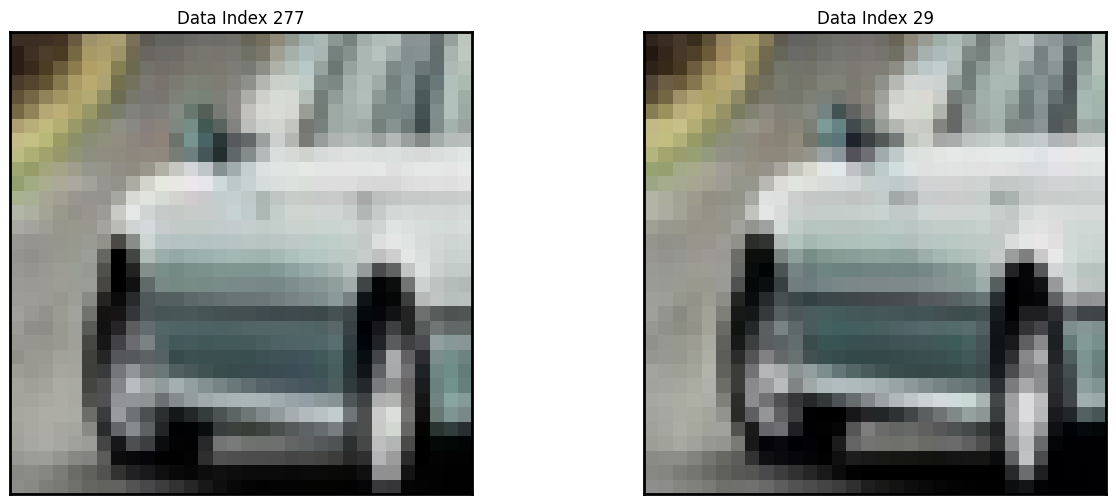

Cluster 2, mean=0.03936486545850821


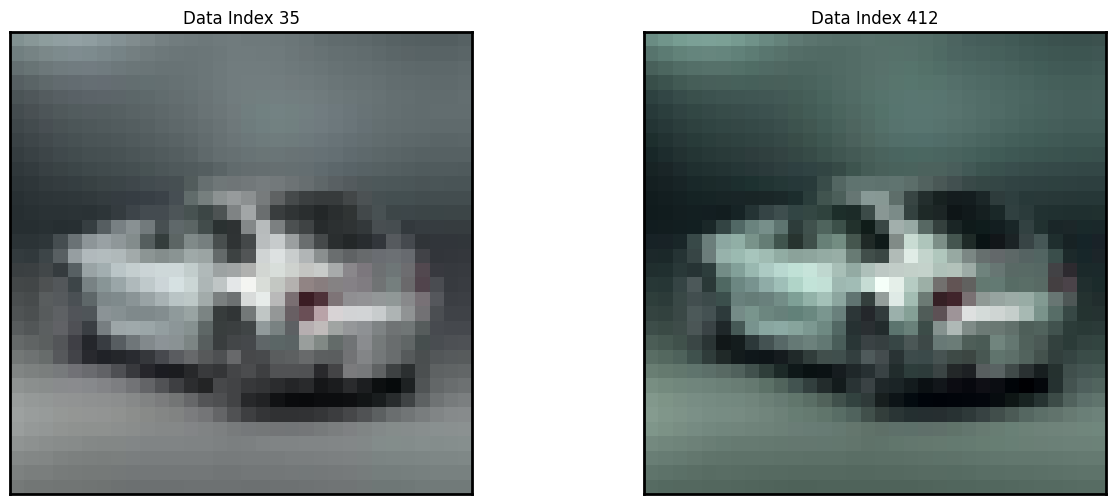

Cluster 3, mean=0.041690445267557455


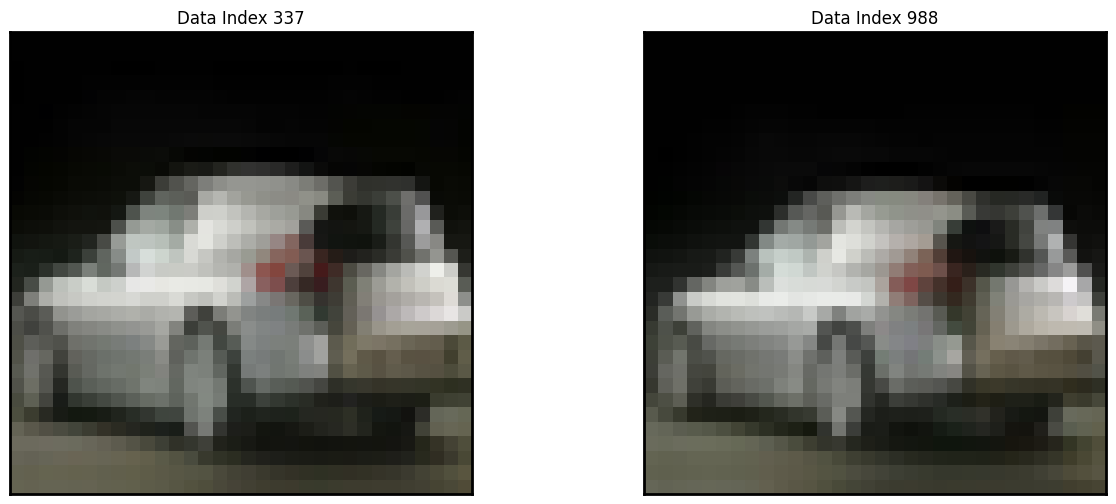

Cluster 4, mean=0.045815143903596346


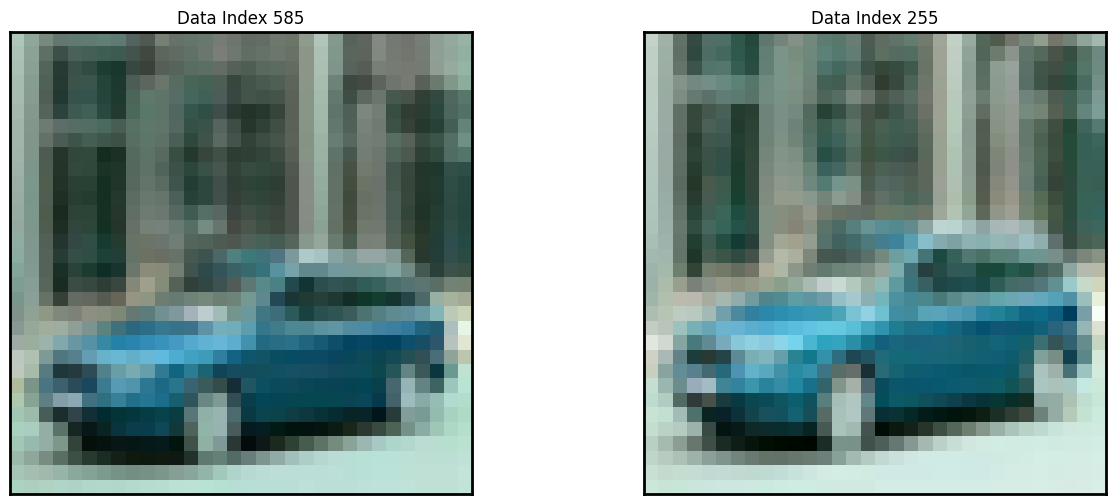

Cluster 5, mean=0.04610623838214931


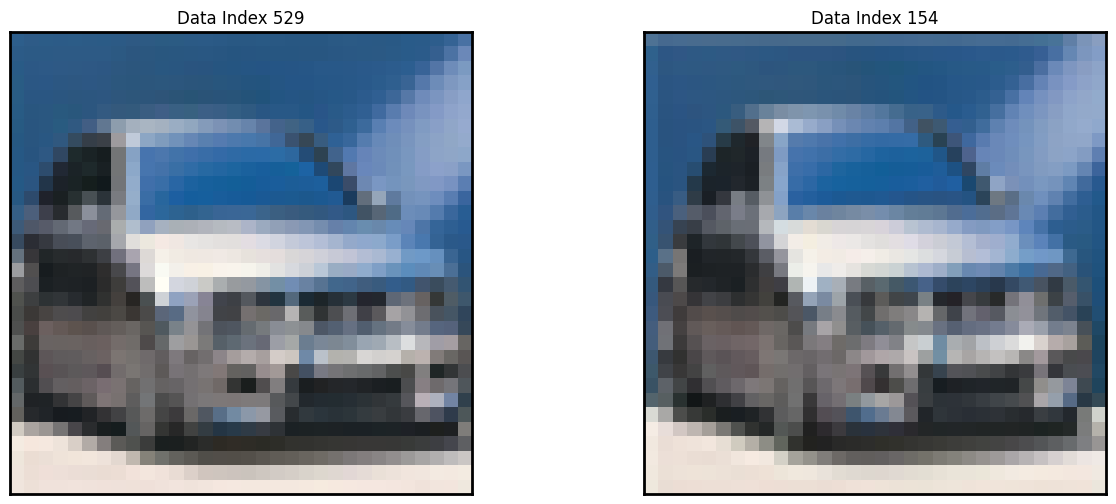

Cluster 6, mean=0.0666361769047631


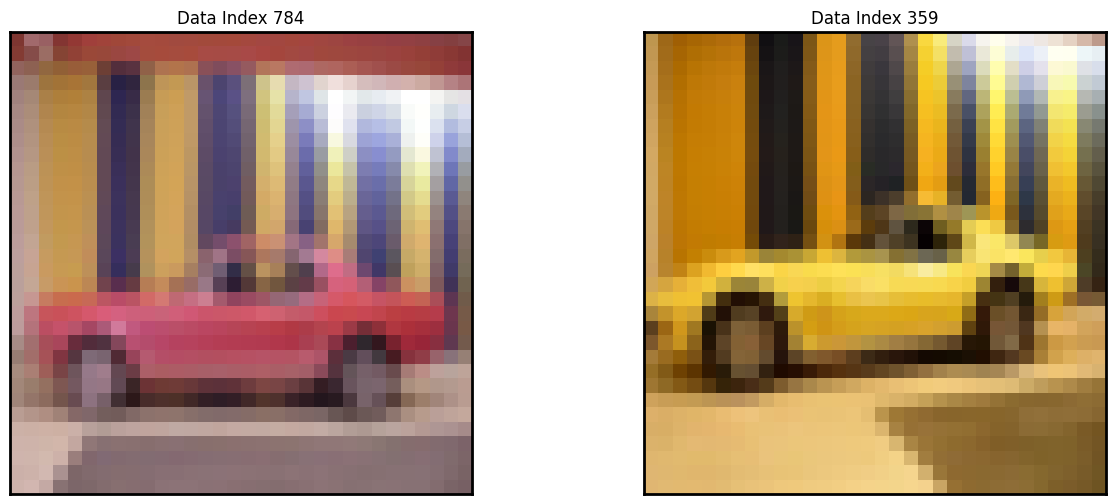

Cluster 7, mean=0.06813008942885165


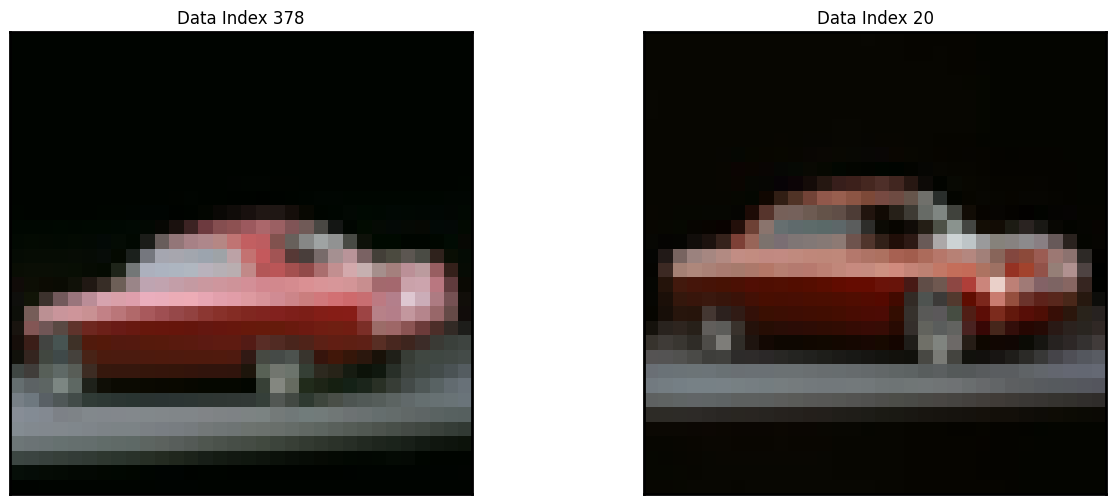

Cluster 8, mean=0.07000000202639715


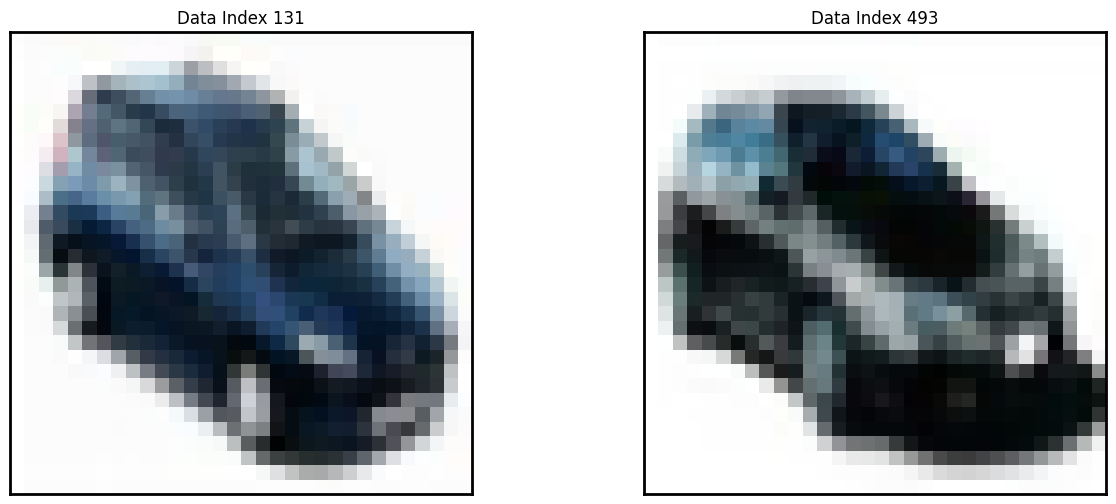

Cluster 9, mean=0.07278965442716448


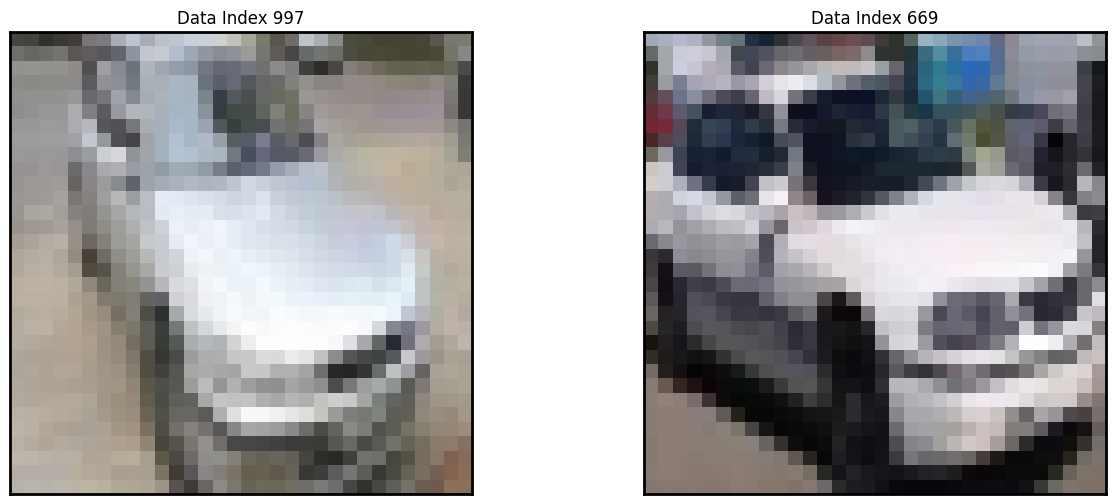

Cluster 10, mean=0.07437479456534801


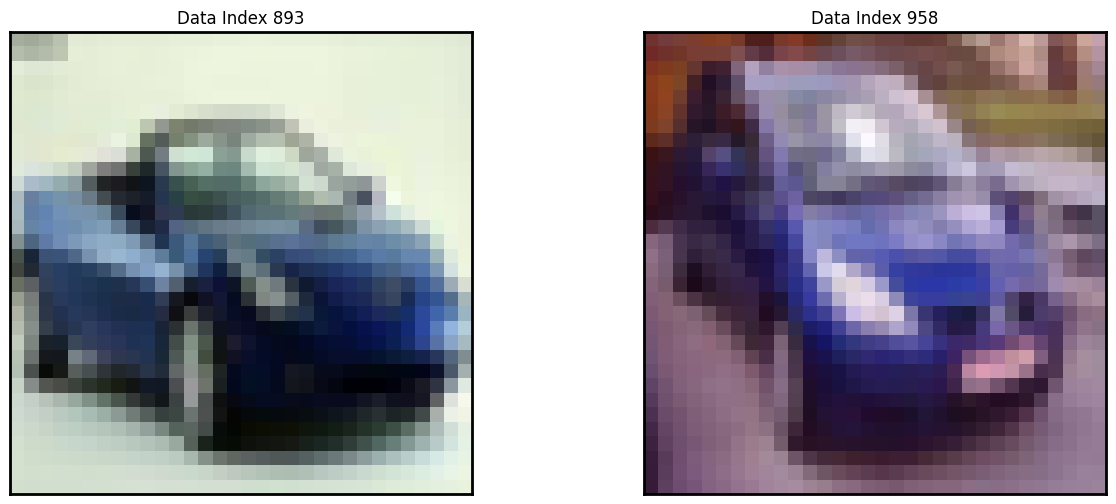

Cluster 11, mean=0.07482252103102402


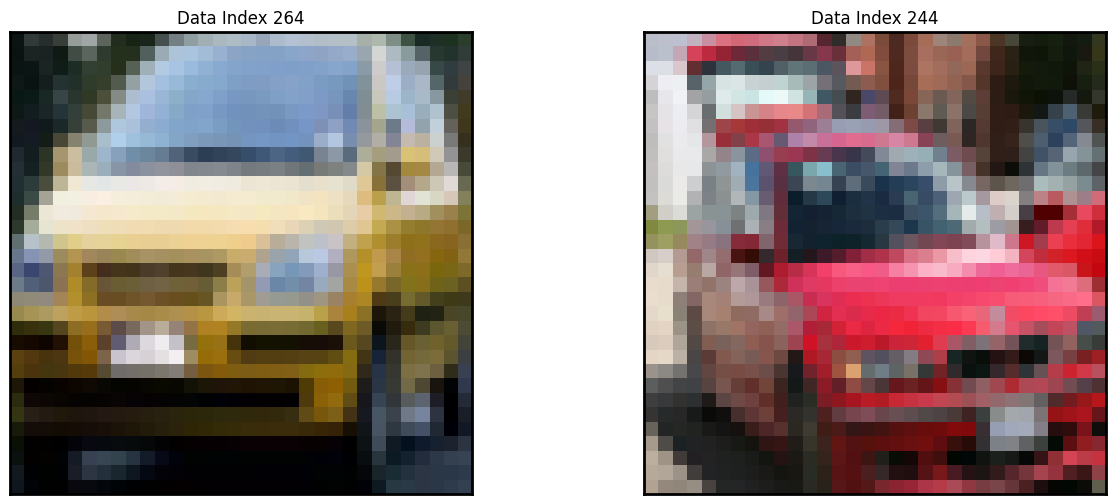

Cluster 12, mean=0.07555529271797118


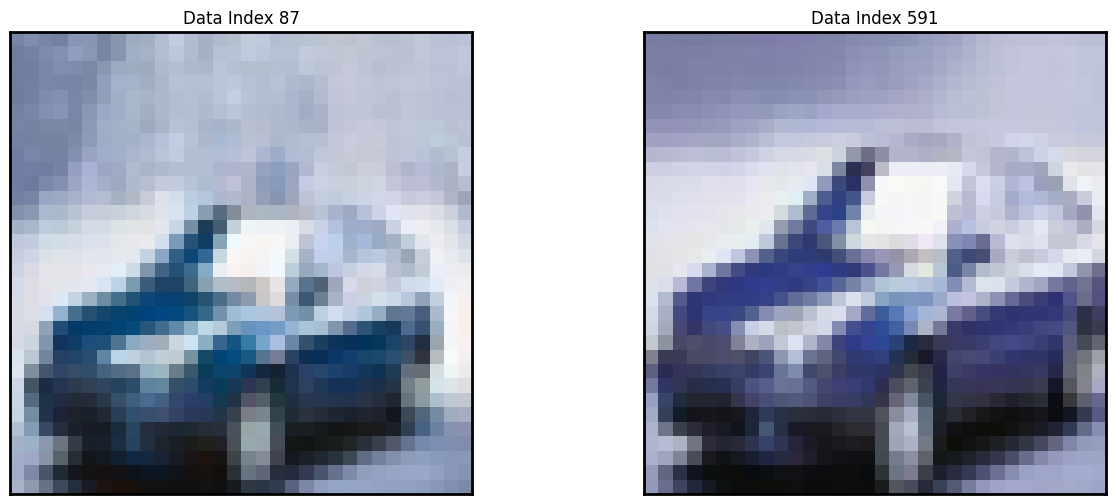

Cluster 13, mean=0.07594935201253666


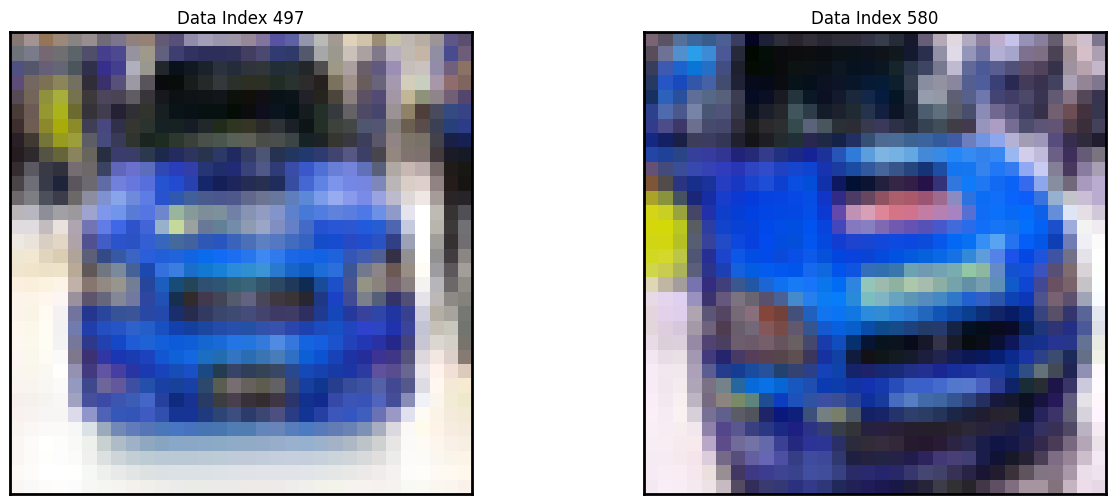

Cluster 14, mean=0.07827381612193389


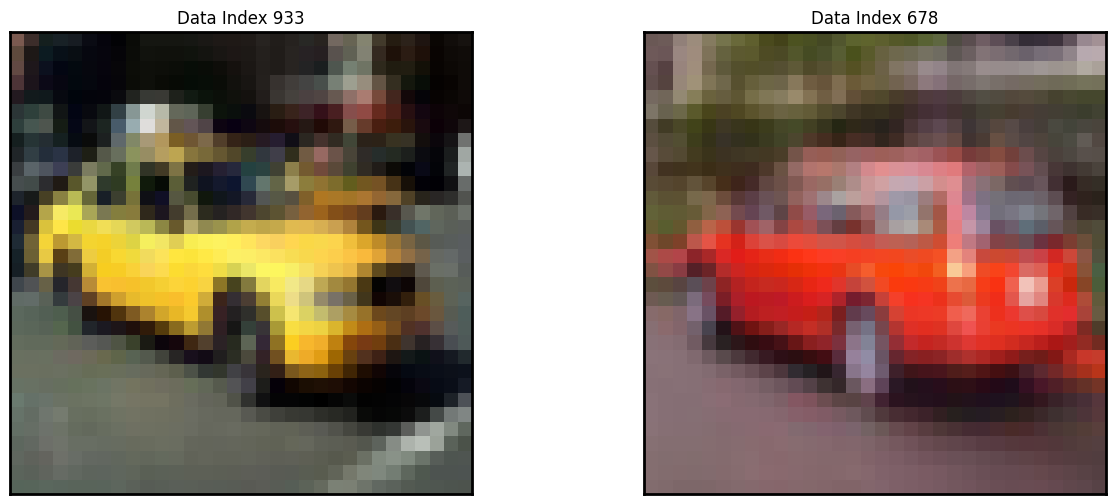

Cluster 15, mean=0.0783769905887243


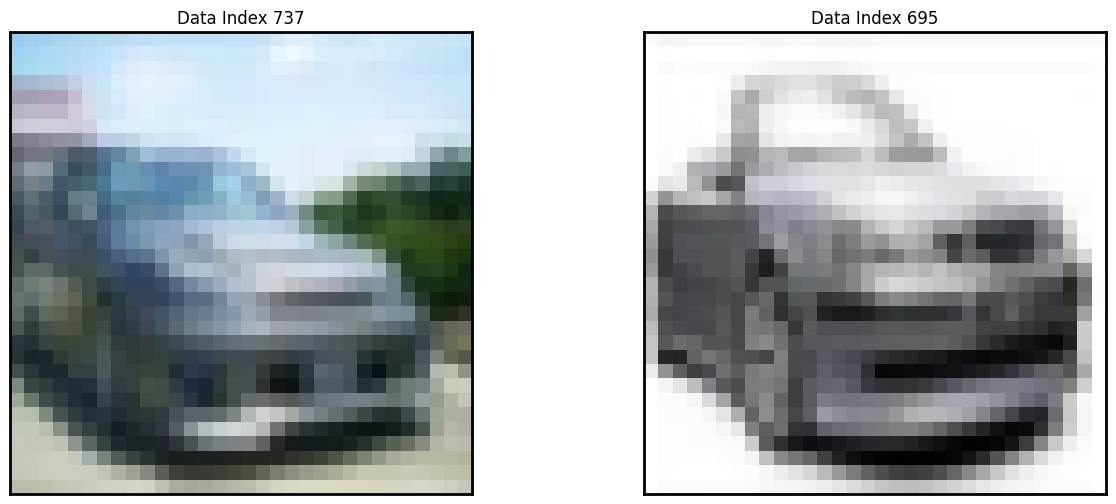

Cluster 16, mean=0.07847343349780554


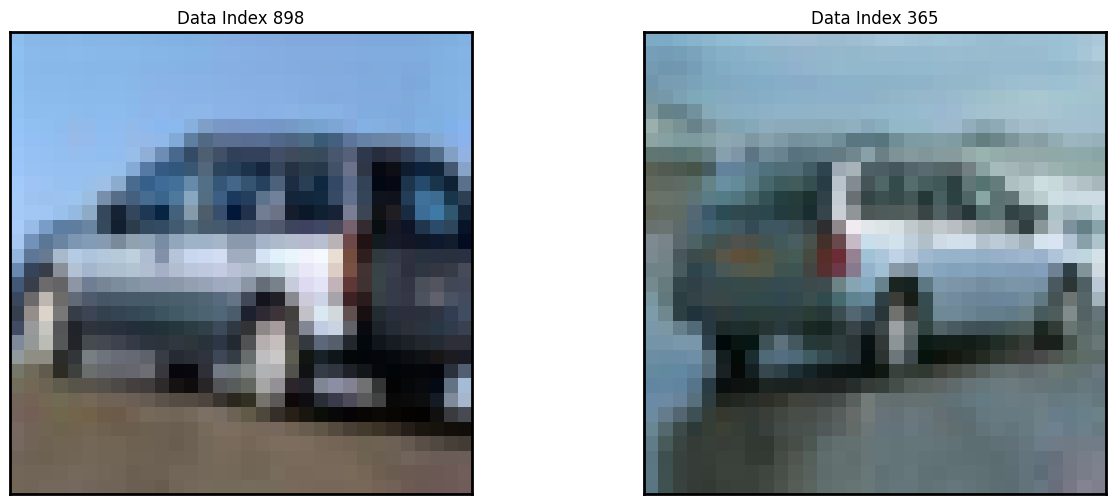

Cluster 17, mean=0.07881288852542623


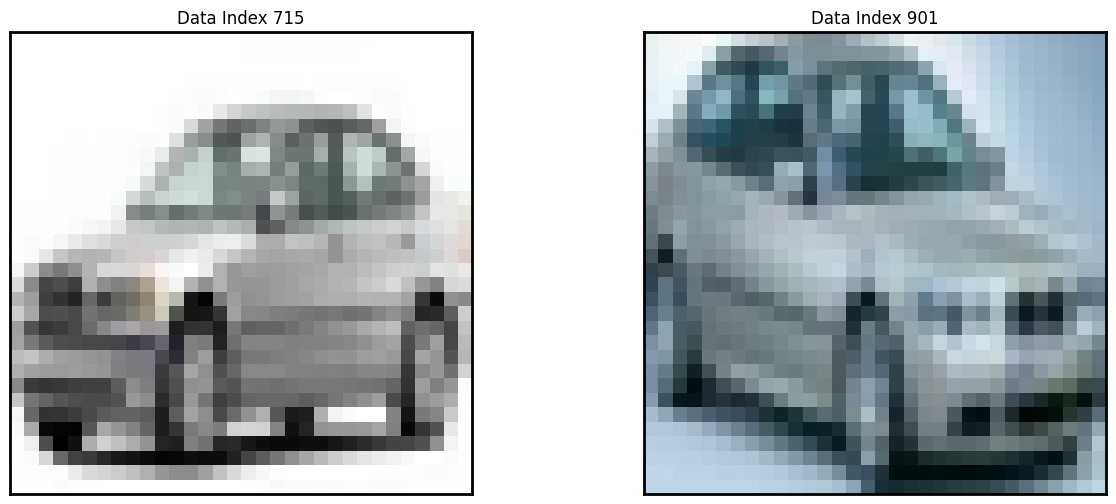

Cluster 18, mean=0.07886424250783301


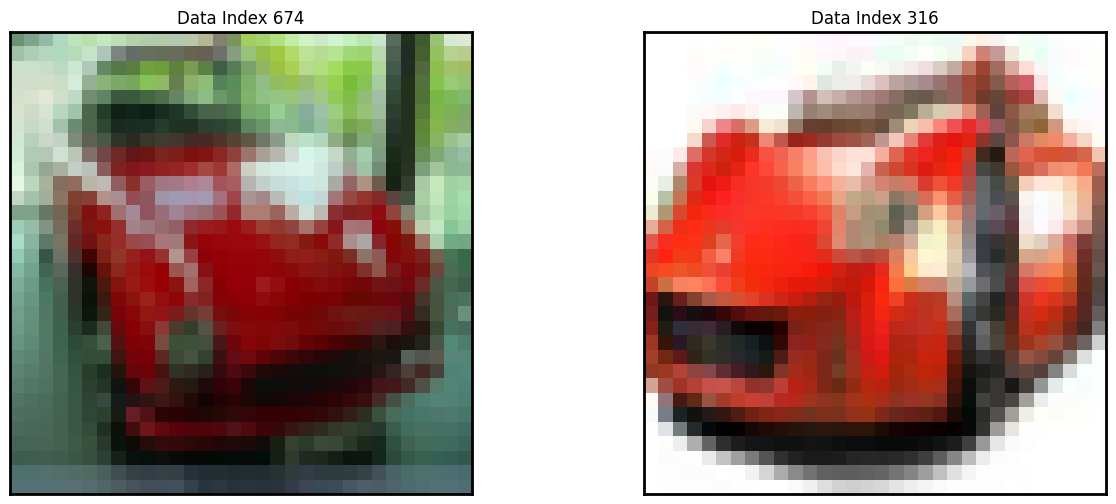

Cluster 19, mean=0.07942910944397738


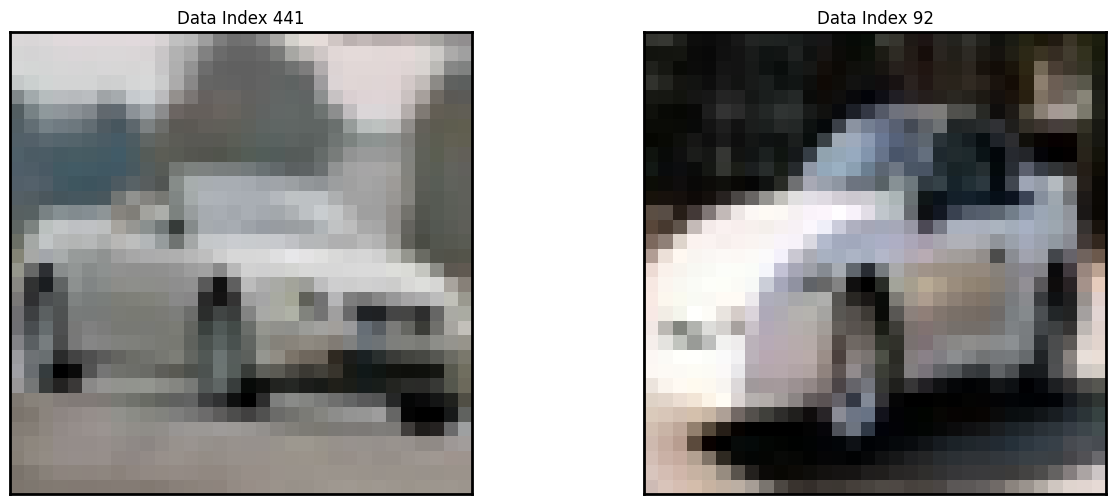

Cluster 20, mean=0.07952772926495724


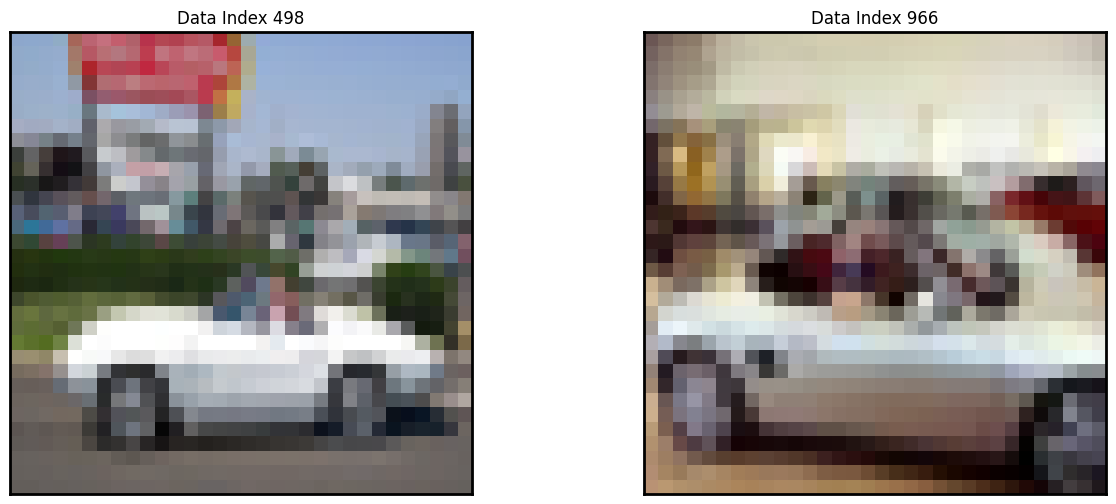

Cluster 21, mean=0.08078756034799049


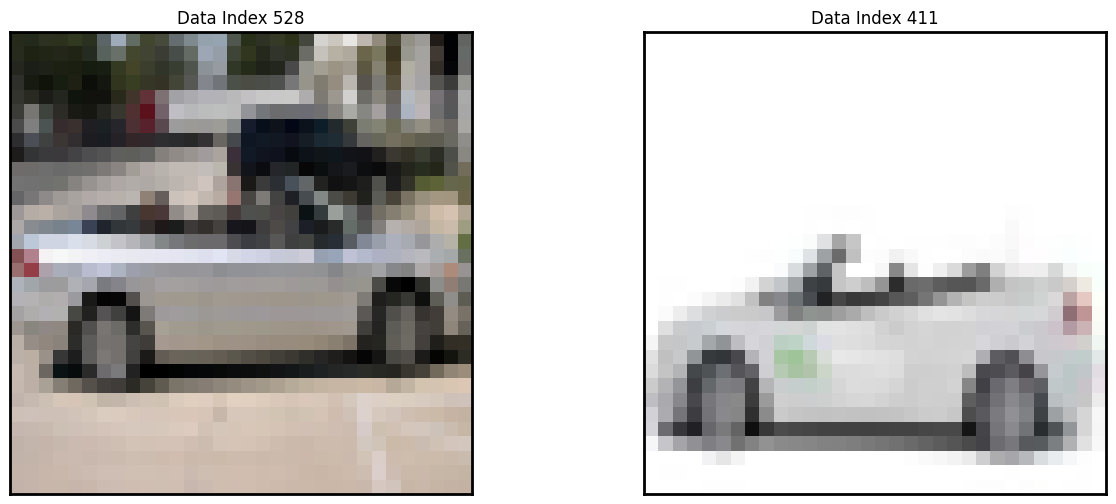

Cluster 22, mean=0.08102892321525096


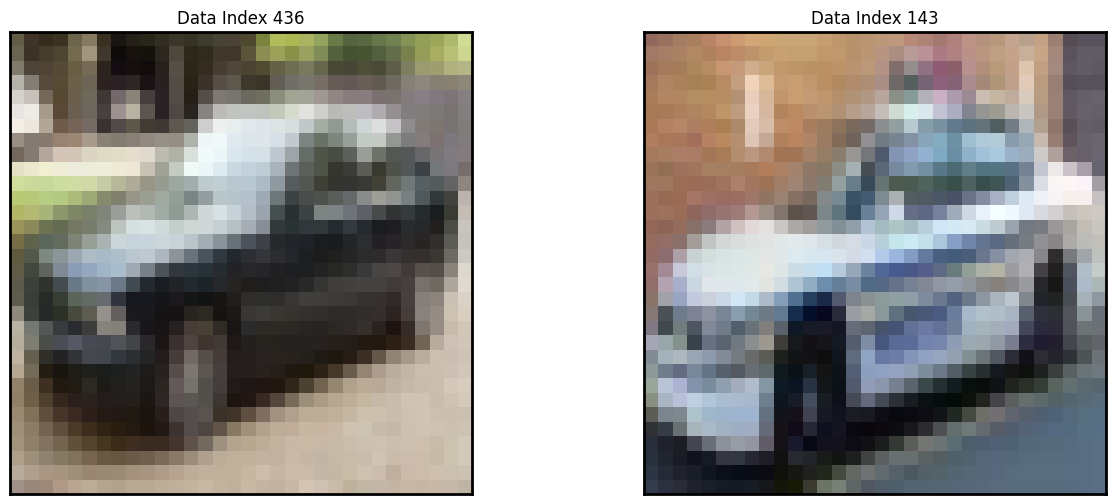

Cluster 23, mean=0.08110790789998917


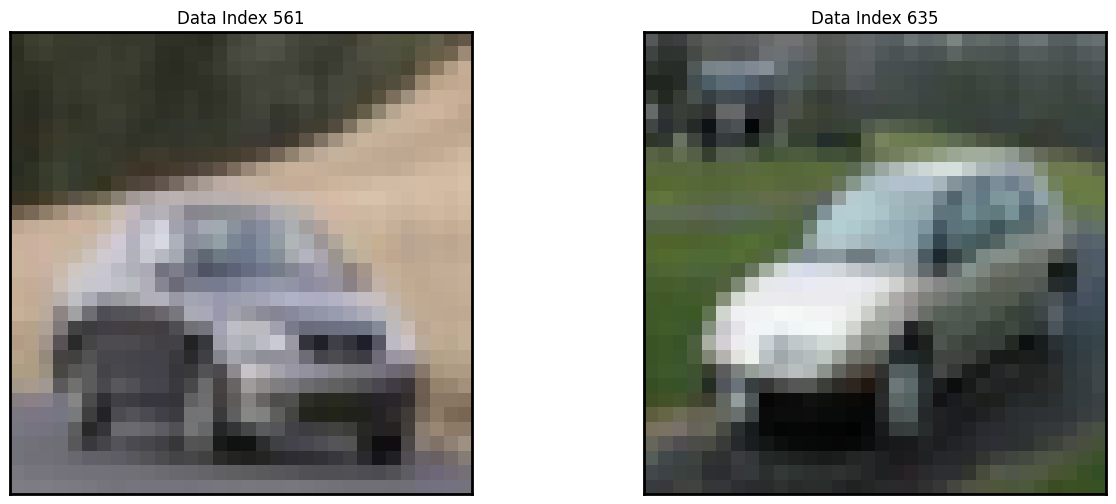

Cluster 24, mean=0.08112189783068244


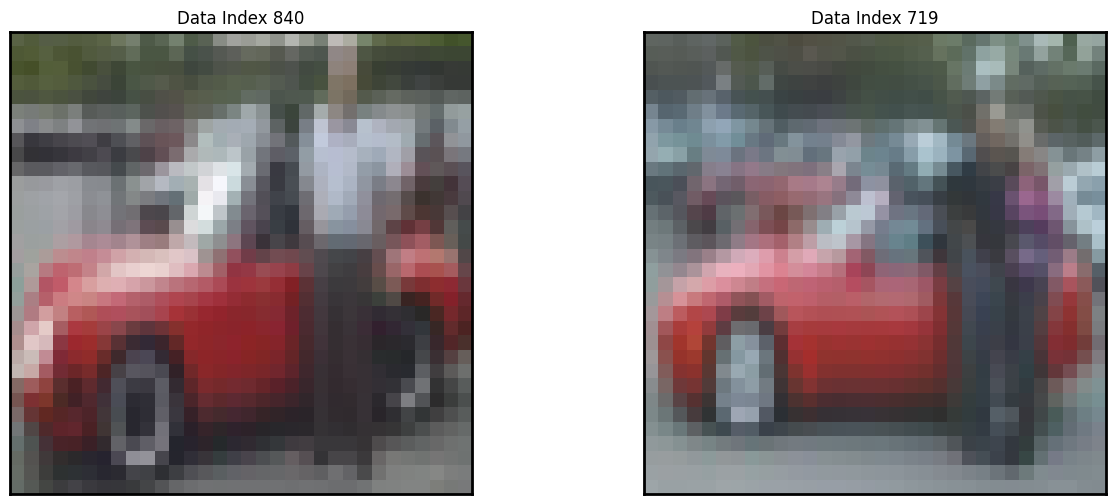

Cluster 25, mean=0.08131657887995992


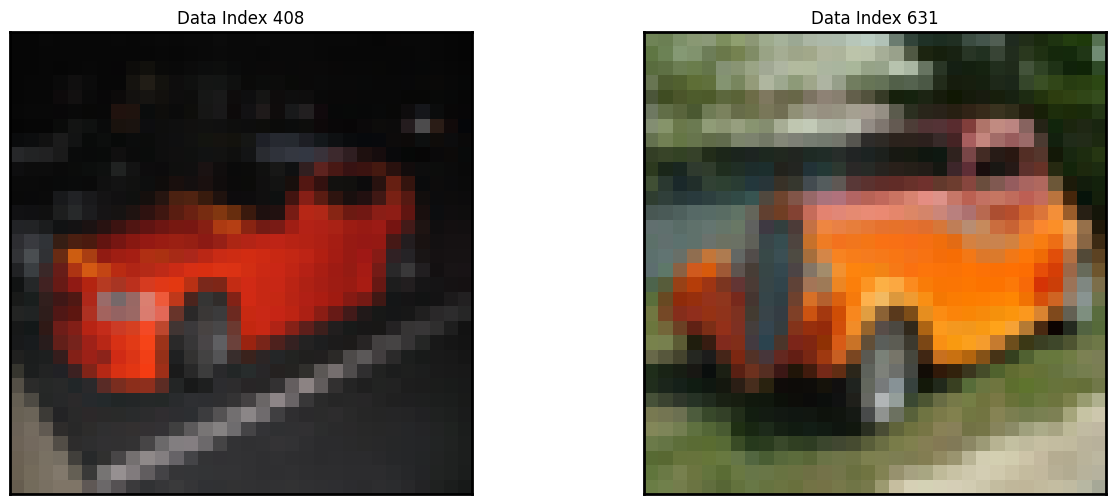

Cluster 26, mean=0.08141633019273807


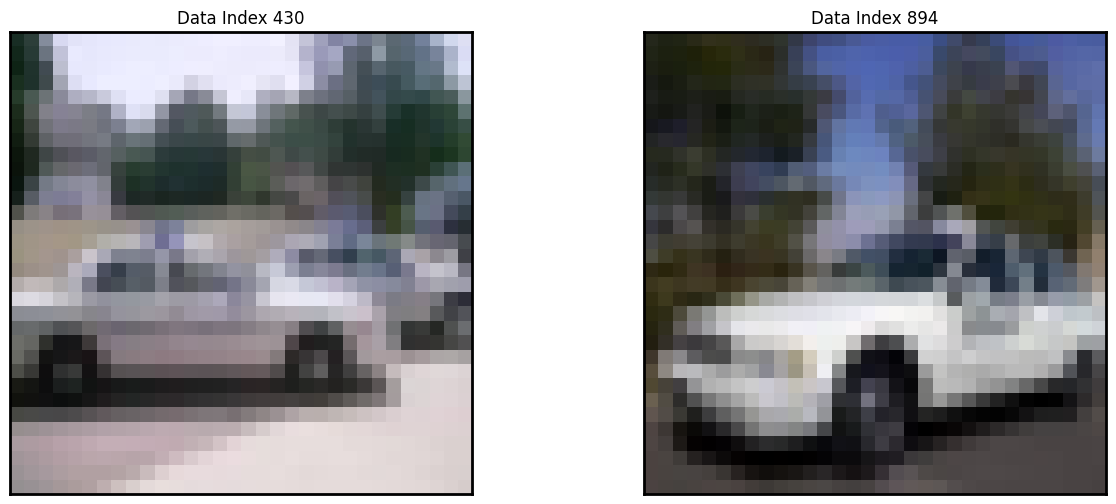

Cluster 27, mean=0.0819050203114375


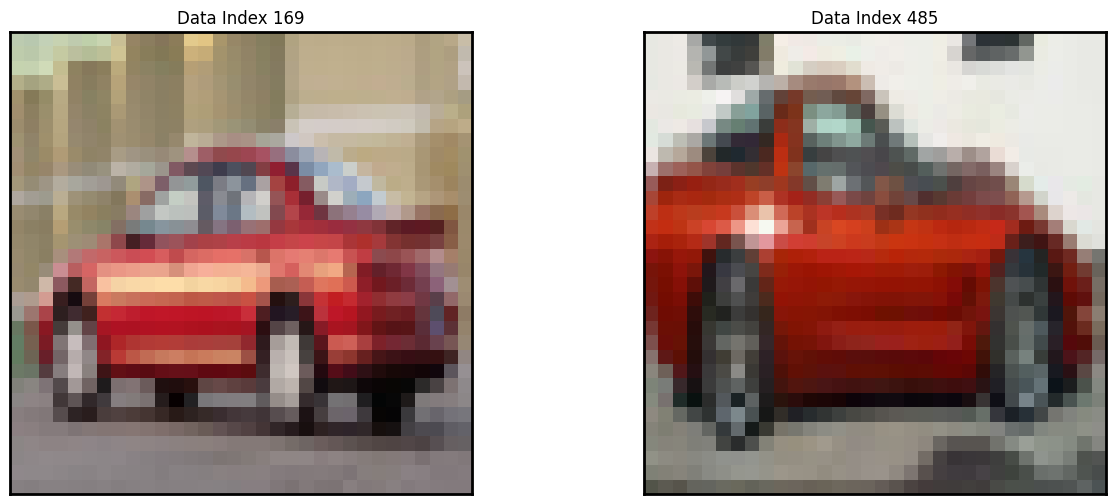

Cluster 28, mean=0.08199818300770936


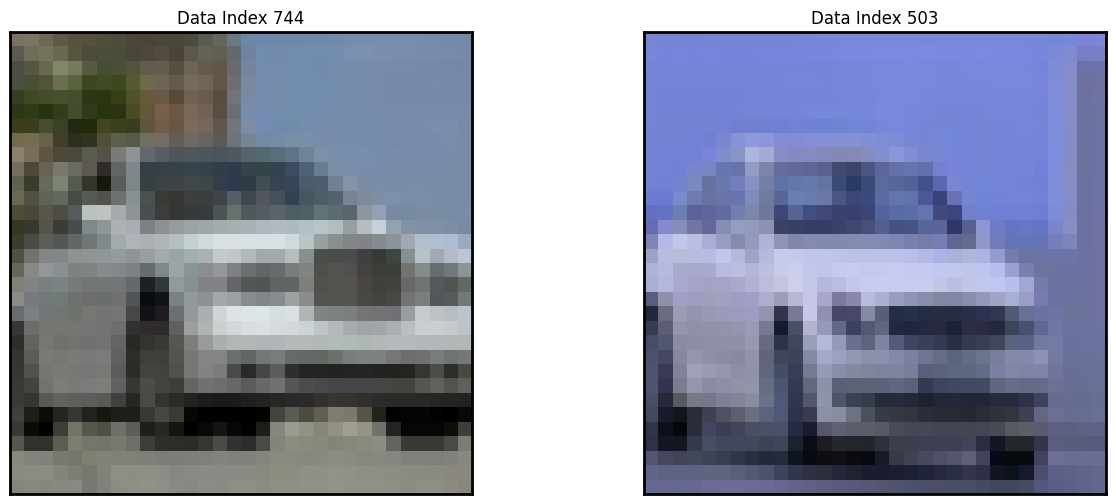

Cluster 29, mean=0.08221313854584715


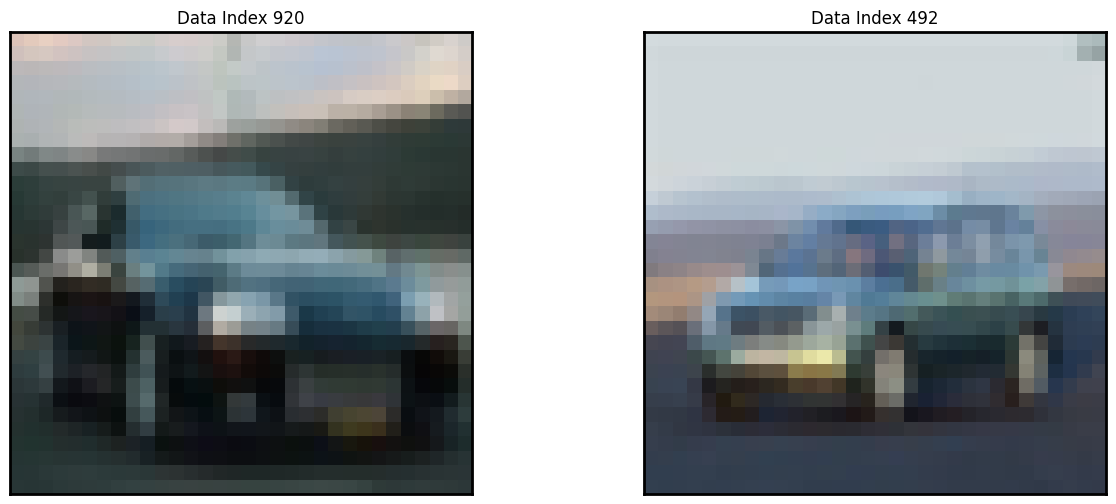

Cluster 30, mean=0.08255852342386971


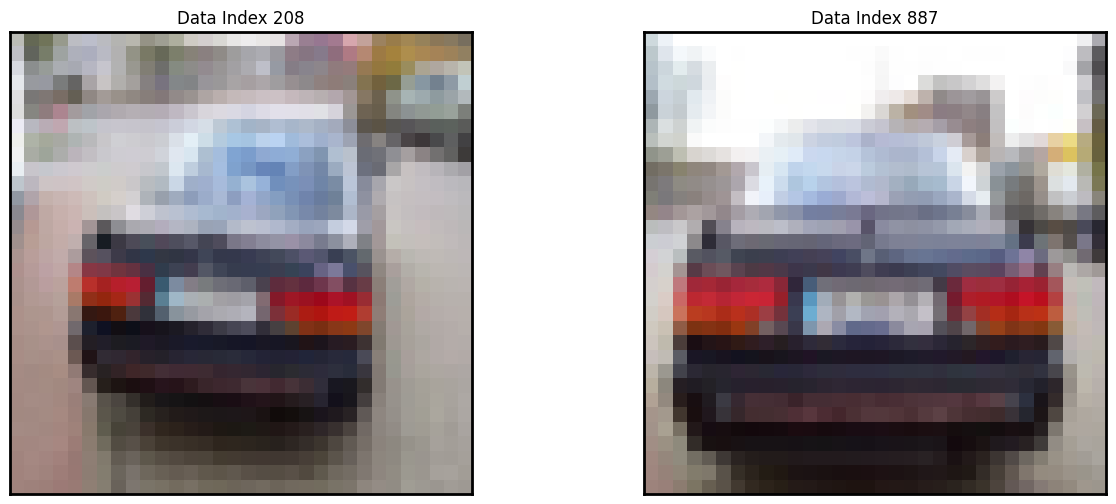

Cluster 31, mean=0.08560591544920199


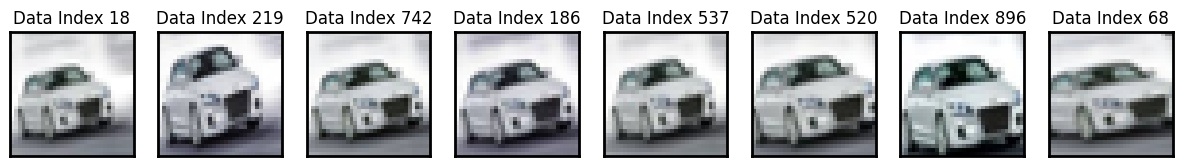

Cluster 32, mean=0.09038723901184452


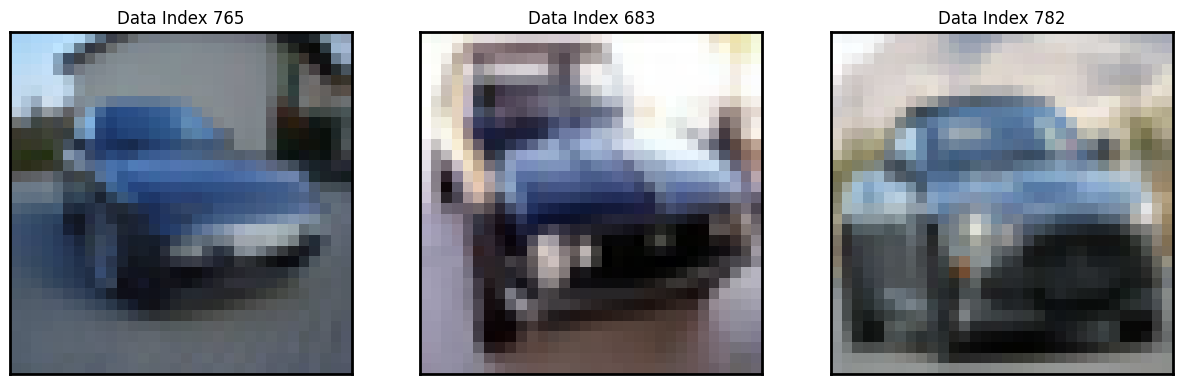

Cluster 33, mean=0.09351502900018221


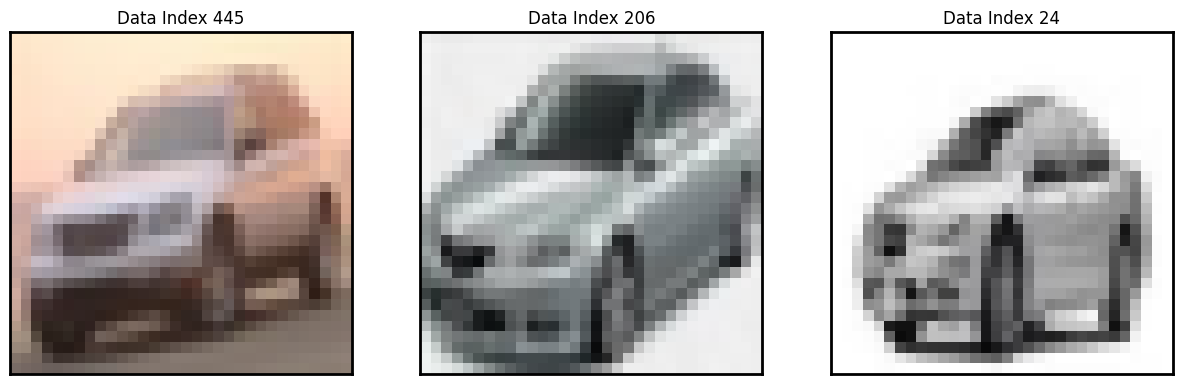

Cluster 34, mean=0.09382722637228569


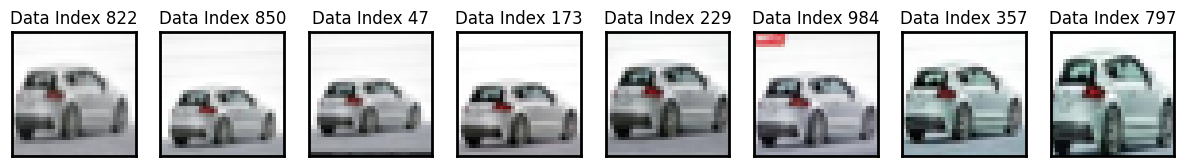

Cluster 35, mean=0.0945012574532164


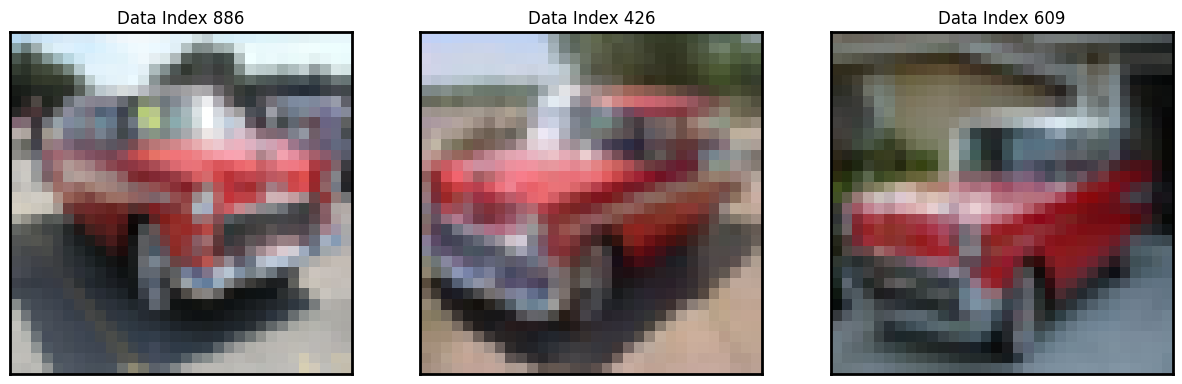

Cluster 36, mean=0.10058589305201292


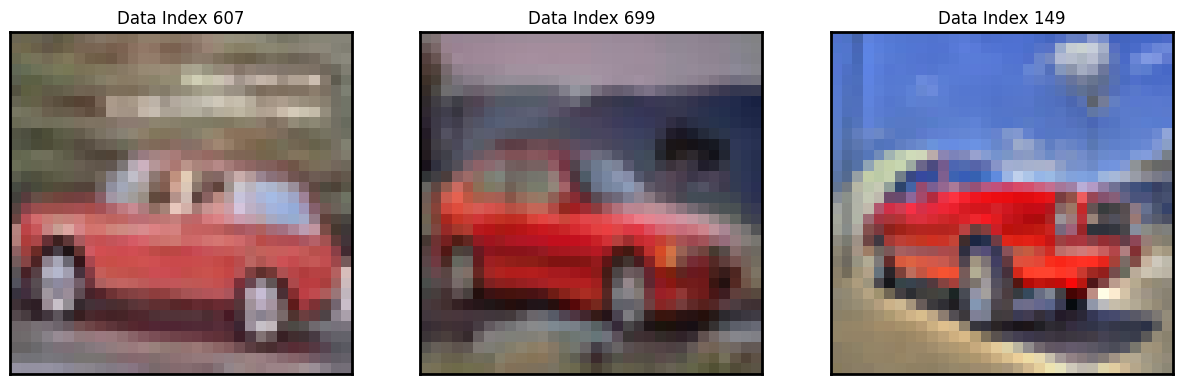

Cluster 37, mean=0.10086152753957517


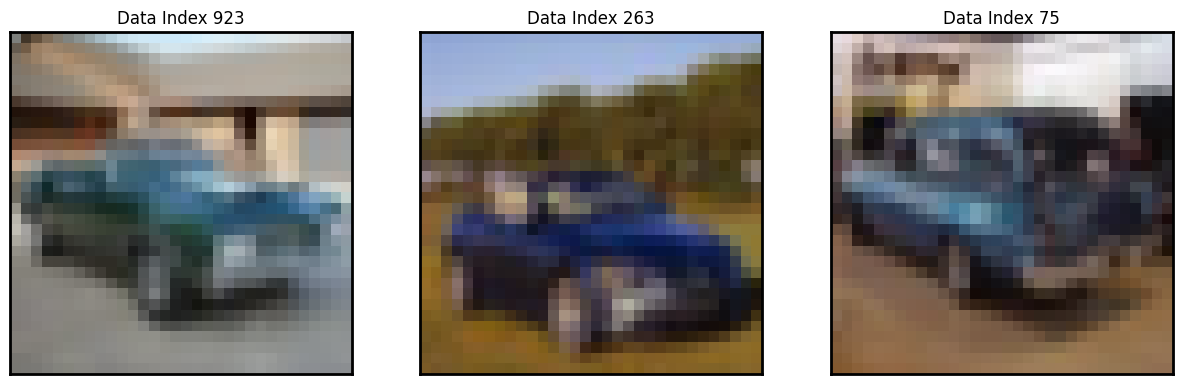

Cluster 38, mean=0.10280631856489635


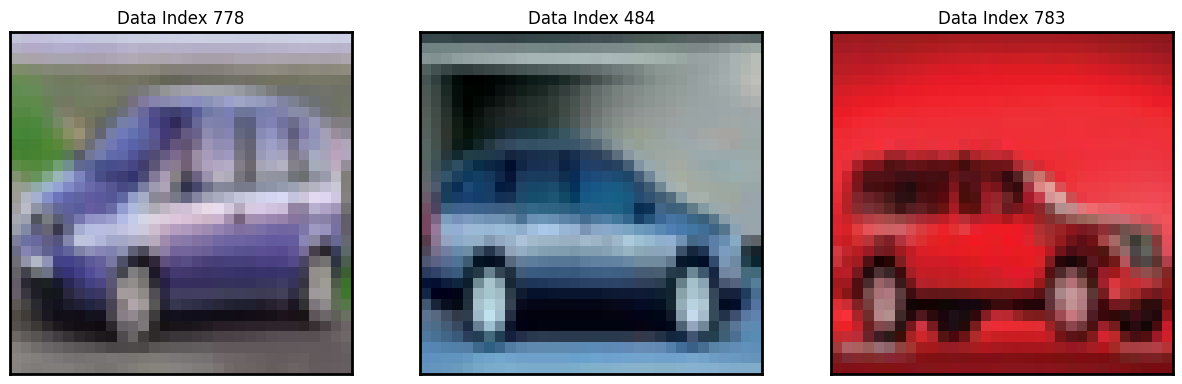

Cluster 39, mean=0.1041755865843788


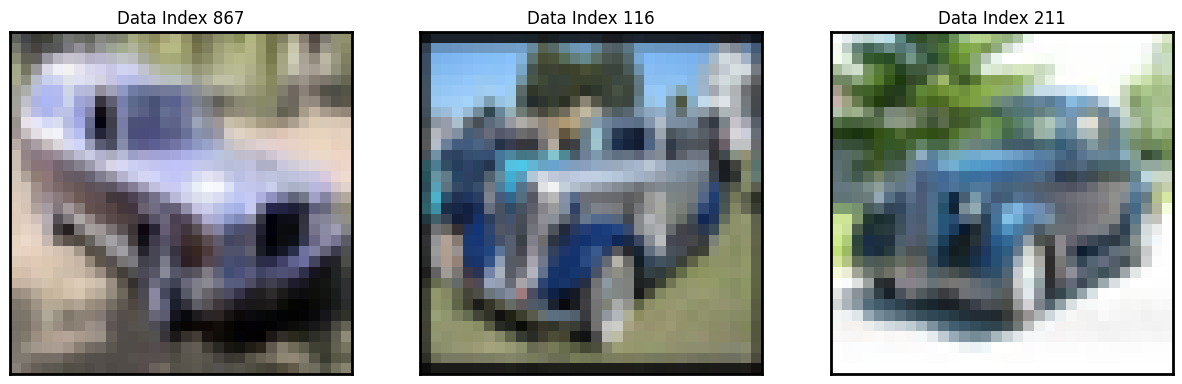

Cluster 40, mean=0.10455398555318285


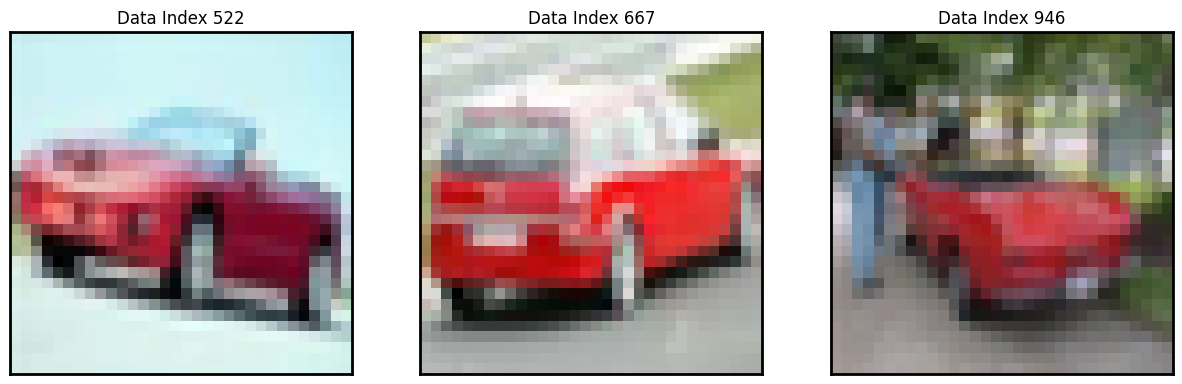

Cluster 41, mean=0.1095649485004057


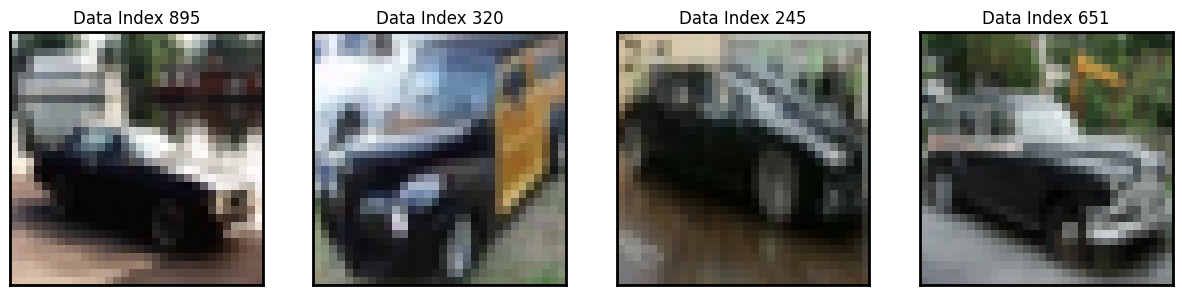

Cluster 42, mean=0.10963883740713729


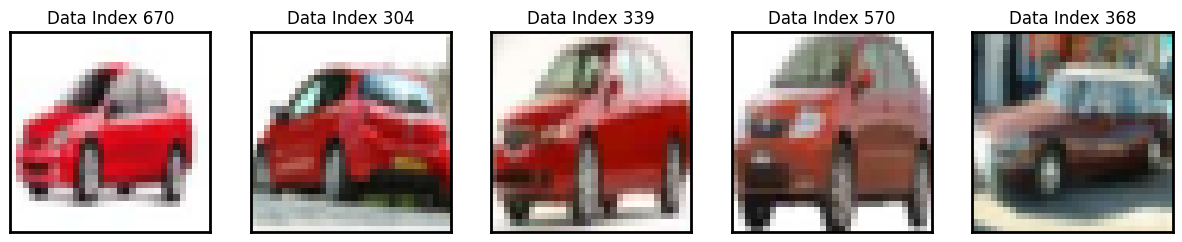

Cluster 43, mean=0.11222288227077729


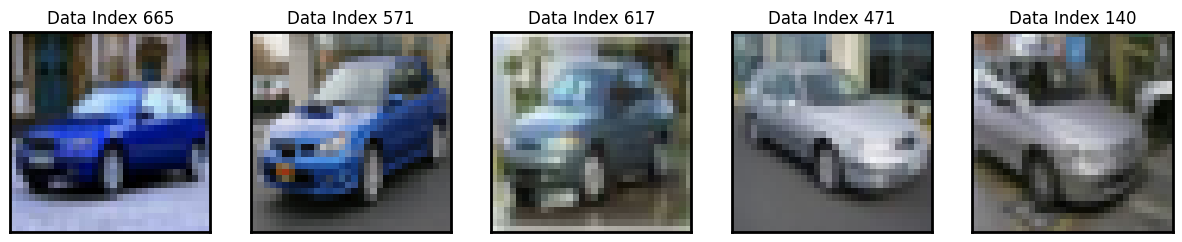

Cluster 44, mean=0.12126647956209377


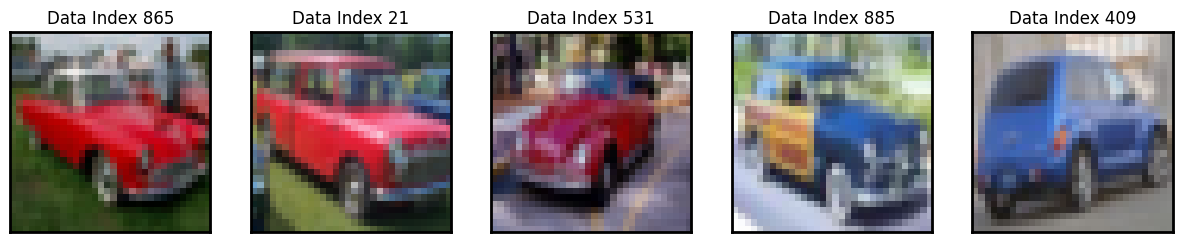

Cluster 45, mean=0.12779536402487487


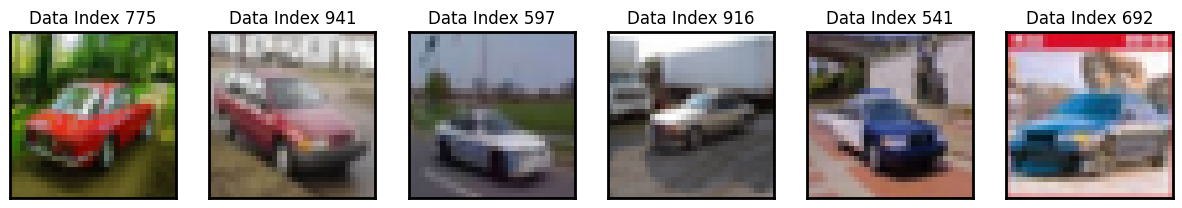

Cluster 46, mean=0.1278340004752266


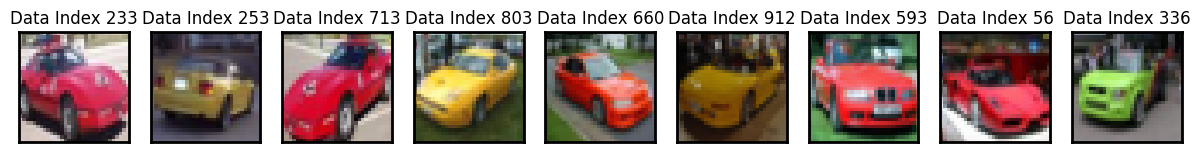

Cluster 47, mean=0.12987753950719633


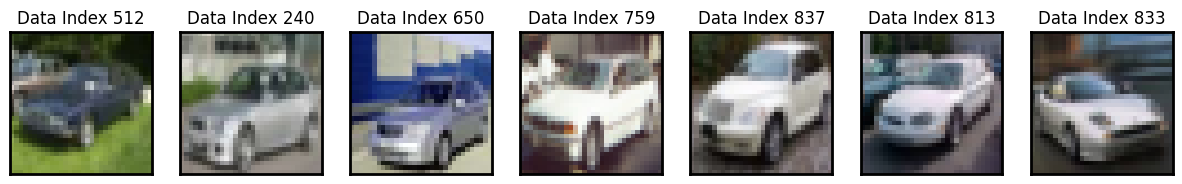

Cluster 48, mean=0.13087322827158704


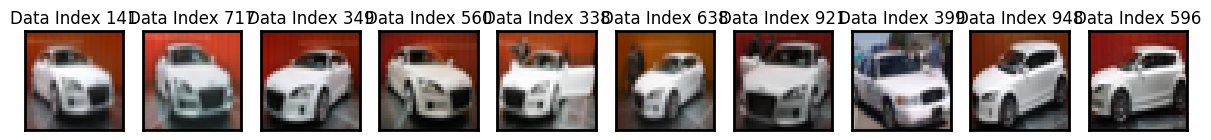

In [6]:
from dnikit.base import Batch
import matplotlib.pyplot as plt

clusters = duplicates.results[requested_response]
sorted_clusters = sorted(clusters, key=lambda x: x.mean)

for cluster_number, cluster in enumerate(sorted_clusters):
    print(f'Cluster {cluster_number + 1}, mean={cluster.mean}')

    img_idx_list = cluster.batch.metadata[Batch.StdKeys.IDENTIFIER]

    f, axarr = plt.subplots(1, len(img_idx_list), squeeze=False, figsize=(15,6))
    for i, img_idx in enumerate(img_idx_list):
        assert isinstance(img_idx, int), "For this example plot, the identifier should be an int"
        axarr[0, i].imshow(images[img_idx])
        plt.setp(axarr[0, i].spines.values(), lw=2)
        axarr[0, i].yaxis.set_major_locator(plt.NullLocator())
        axarr[0, i].xaxis.set_major_locator(plt.NullLocator())
        axarr[0, i].set_title(f'Data Index {img_idx}')
    plt.show()
